In [49]:
from typing import Literal

# Bib joblib, Numpy,skimage,glob,re
from joblib import delayed,Parallel
import numpy as np
import skimage
import glob
import re

# GLCM,LBP,LPQ
from DescritoresDeImagem.glcm import glcm
from DescritoresDeImagem.lbp import lbp
from DescritoresDeImagem.lpq import lpq

# Standart Scale, SVC and KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [50]:
def  glcmimageapply(imgpath,distances=[1,3,5],angles=np.deg2rad([0,90,180,270]))-> np.ndarray[tuple[int],np.dtype[np.float64]]:
    """
    Args
    
    img (np.ndarray): 
        A 2D grayscale image array for which the GLCM is computed. The image 
        should be of type `np.ndarray` and must be 2-dimensional.
            
    distances (Union[List[int], np.ndarray]): 
        A list or array of pixel pair distances for which the GLCM is computed. 
        Default values are [1, 3, 5].
        
    angles (Union[List[float], np.ndarray]): 
        A list or array of angles (in radians) defining the direction for GLCM computation. 
        Default values are the radian equivalents of [0, 90, 180, 270] degrees.
    """
    imgopen=skimage.io.imread(imgpath,as_gray=True) # open image in as gray 
    img_info=glcm(imgopen,distances=distances,angles=angles) # aplly glcm in image open
          
    return img_info 


In [51]:


def lpqimageapply(imgpath, winSize: int = 7,decorr: int = 1,mode: str = 'nh'):
    """
    Applies the LPQ (Local Phase Quantization) method to an image.

    Parameters:
        imgpath (str): Path to the image file.
        winSize (int, optional): Window size for LPQ. Default is 7.
        decorr (int, optional): Decorrelation parameter for LPQ. Default is 1.
        mode (str, optional): Mode for LPQ ('nh' for normalized histogram). Default is 'nh'.

    Returns:
        np.ndarray: Feature vector or matrix produced by the LPQ method.
    """
    imgopen=skimage.io.imread(imgpath,as_gray=True) # open image in as gray 
    img_info=lpq(imgopen,winSize=winSize,mode=mode,decorr=decorr) # aplly glcm in image open
          
    return img_info 


In [52]:
def lbpimageaplly(imgpath,P: int = 8,R: int = 2,method: Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform'):
    """
    Applies the LBP (Local Binary Patterns) method to an image.

    Parameters:
        imgpath (str): Path to the image file.
        P (int, optional): Number of circularly symmetric neighbor points. Default is 8.
        R (int, optional): Radius of the circle. Default is 2.
        method (Literal, optional): Method to extract LBP. Options include:
            - 'default': Basic LBP.
            - 'ror': Rotation invariant.
            - 'uniform': Uniform patterns only.
            - 'nri_uniform': Non-rotation-invariant uniform patterns.
            - 'var': Variance-based patterns. Default is 'nri_uniform'.

    Returns:
        np.ndarray: The resulting LBP image or feature vector.
    """
    
    imgopen=skimage.io.imread(imgpath,as_gray=True) # open image in as gray 
    
    img_info=lbp(image=imgopen,P=P,R=R,method=method) # aplly glcm in image open
          
    return img_info


In [53]:
def writendarry(filename:str,array:np.ndarray,delimiter="|")->None:
    """
    Parameters:
        filename (str):Path to the image file.
        array(np.ndarray):Data write file.
        delimiter(str): string to delimiter  data.
    """
    with open(file=filename,mode="w") as file:
        for i in array:
            file.writelines(np.array2string(i,separator=","))
            file.write(delimiter)
            

In [54]:
def readfilendarray(filename:str,delimiter="|",data="f")->np.ndarray:
    """
    Applies the LBP (Local Binary Patterns) method to an image.

    Parameters:
        filename(str): Path to the image file.
        delimiter(str): string to delimiter data.
        data: type of data in file (s(str) or f(float))        
    Returns:
        np.ndarray: the feature vector.
    """
    if data=="f":
        array=[]
        with open(file=filename,mode="r") as f:
            lines=f.read().split(delimiter)
            for datastr in lines:
                data=datastr.replace("\n","").replace(" ","").strip("[]").split(",")
                arr=[float(i) for i in data if i.strip()]
                array.append(arr)
            array.pop()
            return np.array(array)
    elif data=="s":
        with open(file=filename,mode="r") as f:
            lines=f.read().replace("'","").split(delimiter)
            lines.pop()
            return np.array(lines)
            

In [55]:
def extractimagesdescriptor(filename:str,descriptor:Literal["LPQ","LBP","GLCM"] = 'GLCM',jobs_n:int=-1):
    pathimageitetor=glob.glob("BaseDeDados/*.bmp")
    
    if descriptor=="LPQ":
        def lpq_function(method:Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform',P:int = 8,R:int=2): 
            datasetlpq=Parallel(n_jobs=jobs_n)(delayed(lbpimageaplly)(i,P,R,method) for i in pathimageitetor)
            writendarry(filename=filename,array=datasetlpq)
        y_result=[]
        for i in pathimageitetor:
            y_result.append(re.sub(r'\d','',i.replace("BaseDeDados/","").replace(".bmp","")))
        writendarry("DadosExtraidos/Y_Resultado.txt",np.array(y_result))
        return lpq_function
    elif descriptor=="LBP":
        def lbp_function(winSize: int = 7,decorr: int = 1,mode: str = 'nh'):
            datasetlbq=Parallel(n_jobs=jobs_n)(delayed(lpqimageapply)(i,winSize,decorr,mode) for i in pathimageitetor)
            writendarry(filename=filename,array=datasetlbq)
        y_result=[]
        for i in pathimageitetor:
            y_result.append(re.sub(r'\d','',i.replace("BaseDeDados/","").replace(".bmp","")))
        writendarry("DadosExtraidos/Y_Resultado.txt",np.array(y_result))
        return lbp_function
    elif descriptor=="GLCM":
        def glcm_function(distances= [1, 3, 5],angles= np.deg2rad([0, 90, 180, 270])):
            datasetlbq=Parallel(n_jobs=jobs_n)(delayed(glcmimageapply)(i,distances,angles) for i in pathimageitetor)
            writendarry(filename=filename,array=datasetlbq)
        y_result=[]
        for i in pathimageitetor:
            y_result.append(re.sub(r'\d','',i.replace("BaseDeDados/","").replace(".bmp","")))
            writendarry("DadosExtraidos/Y_Resultado.txt",np.array(y_result))
        return glcm_function
    
   


In [56]:
distances=[2,4,8,16,32]

angles=np.deg2rad([90,180,270])

DESCRIPTOR="GLCM"

function_glcm=extractimagesdescriptor("DadosExtraidos/X_TreinoGLCM.txt",descriptor="GLCM")
function_glcm(angles=angles,distances=distances)

function_lpq=extractimagesdescriptor(filename="DadosExtraidos/X_TreinoLPQ.txt",descriptor="LPQ")
function_lpq()

function_lbp=extractimagesdescriptor(filename="DadosExtraidos/X_TreinoLBP.txt",descriptor="LBP")
function_lbp()

X_lbp=readfilendarray(filename="DadosExtraidos/X_TreinoLBP.txt")
X_glcm=readfilendarray(filename="DadosExtraidos/X_TreinoGLCM.txt")
X_lpq=readfilendarray(filename="DadosExtraidos/X_TreinoLPQ.txt")
y=readfilendarray(filename="DadosExtraidos/Y_Resultado.txt",data="s")


In [57]:
CVPARTS=5 # number of CV parts

pipe=Pipeline(steps=[("scalar",StandardScaler()),
                     ("model",SVC(kernel="rbf"))]) 
parameters={
    "model__C":[1000,1000,10000],
    "model__gamma":["auto","scale"]
}

svm=GridSearchCV(estimator=pipe,
                    param_grid=parameters,
                    scoring="f1_macro",
                    cv=CVPARTS,n_jobs=-1)

In [58]:
if DESCRIPTOR=="GLCM":
    svm.fit(X=X_glcm,y=y)
elif DESCRIPTOR=="LBP":
    svm.fit(X=X_lbp,y=y)
elif DESCRIPTOR=="LPQ":
    svm.fit(X=X_lbp,y=y)

In [59]:
if DESCRIPTOR=="GLCM":
    ypred=svm.predict(X=X_glcm)
elif DESCRIPTOR=="LBP":
    ypred=svm.predict(X=X_lbp)
elif DESCRIPTOR=="LPQ":
    ypred=svm.predict(X=X_lpq)

In [60]:
print(f"Acurácia do modelo: {accuracy_score(y_true=y,y_pred=ypred)}\n")

print(f"Precisão do modelo: {precision_score(y_true=y,y_pred=ypred,average='macro')}\n")

print(f"f1 score do modelo: {f1_score(y_true=y,y_pred=ypred,average='macro')}\n")

print(f"Recall do modelo: {recall_score(y_true=y,y_pred=y,average='macro')}\n")

Acurácia do modelo: 0.9826666666666667

Precisão do modelo: 0.9828570800648379

f1 score do modelo: 0.9826827045403107

Recall do modelo: 1.0



In [61]:
print(classification_report(y,y_pred=ypred))



              precision    recall  f1-score   support

           a       1.00      1.00      1.00       250
          ad       0.98      1.00      0.99       250
           d       0.96      0.98      0.97       250
           f       0.99      0.96      0.98       250
           j       0.96      0.97      0.96       250
          jd       0.99      0.96      0.98       250
          jt       0.99      0.98      0.99       250
           m       0.99      1.00      0.99       250
          md       1.00      0.99      1.00       250
           n       1.00      0.99      1.00       250
           o       0.98      0.96      0.97       250
           s       0.96      0.99      0.97       250

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



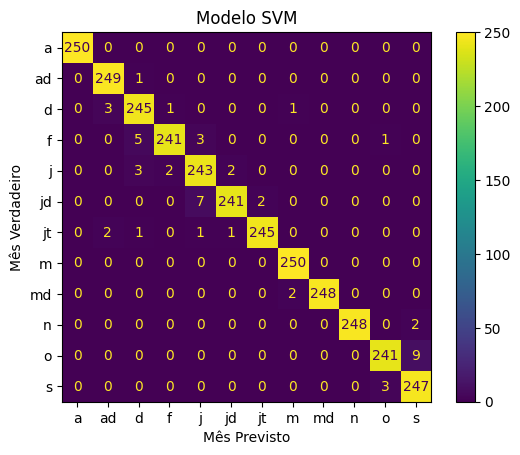

In [62]:
#Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y,ypred)

plt.title("Modelo SVM")

plt.xlabel("Mês Previsto")

plt.ylabel("Mês Verdadeiro")

plt.show()

